In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import PIL
from PIL import Image
import random
import sklearn
import sys
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import torchvision
from collections import Counter
from keras import regularizers
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Sequential
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm
from tqdm.notebook import tqdm
from tqdm.version import __version__ as tqdm__version__


In [2]:
folder_path = "C:/Users/DOCTOR PC/Documents/AI/emotion/images"
train_dir = folder_path + '/train/'
val_dir = folder_path + '/validation/'

In [3]:
emotions = ['happy', 'angry', 'sad', 'surprise', 'neutral', 'fear', 'disgust']

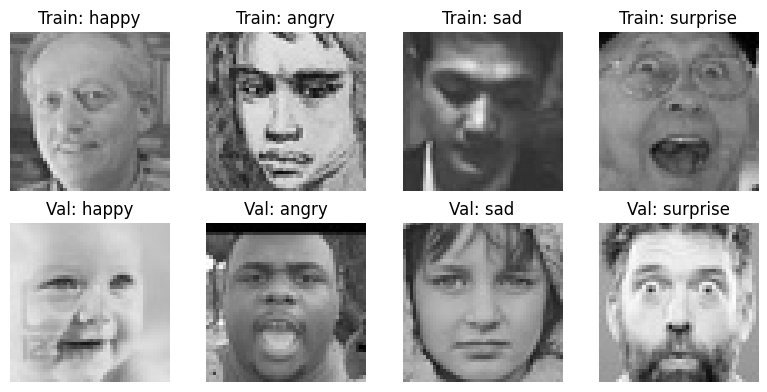

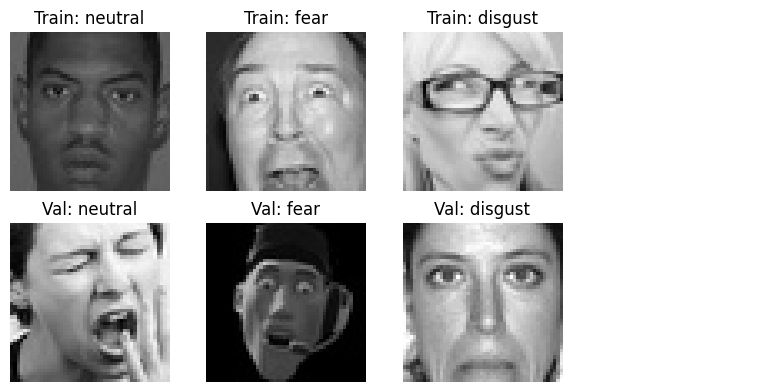

In [4]:
picture_size = 48

for i in range(0, len(emotions), 4):
    fig, axs = plt.subplots(2, 4, figsize=(8, 4))  # 2 rows, 4 columns (train | val for each emotion)
    axs = axs.flatten()
    for j, emotion in enumerate(emotions[i:i+4]):
        # Training image
        train_files = os.listdir(os.path.join(folder_path, "train", emotion))
        random.shuffle(train_files)
        train_img_path = os.path.join(folder_path, "train", emotion, train_files[0])
        train_img = load_img(train_img_path, target_size=(picture_size, picture_size))
        axs[j].imshow(train_img)
        axs[j].set_title(f"Train: {emotion}")
        axs[j].axis('off')
        
        # Validation image
        val_files = os.listdir(os.path.join(folder_path, "validation", emotion))
        random.shuffle(val_files)
        val_img_path = os.path.join(folder_path, "validation", emotion, val_files[0])
        val_img = load_img(val_img_path, target_size=(picture_size, picture_size))
        axs[j+4].imshow(val_img)
        axs[j+4].set_title(f"Val: {emotion}")
        axs[j+4].axis('off')
        
    # Hide unused subplots if emotions are not a multiple of 4
    for k in range(j+1, 4):
        axs[k].axis('off')
        axs[k+4].axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
#use this one , looks more professional

class_directories = os.listdir(train_dir)
class_distributions_dict = {}

for subdirectory in class_directories:
    dir = os.path.join(train_dir, subdirectory)
    files = os.listdir(dir)  # Use 'files' to store the list of files
    num_files = len(files)  # Get the number of files
    class_distributions_dict[subdirectory] = num_files  # Correct dictionary assignment
 

class_distributions = pd.Series(class_distributions_dict)

print("class_distributions type:", type(class_distributions))
print("class_distributions shape:", class_distributions.shape)
print(class_distributions)

class_distributions type: <class 'pandas.core.series.Series'>
class_distributions shape: (7,)
angry       3993
disgust      436
fear        4103
happy       7164
neutral     4982
sad         4938
surprise    3205
dtype: int64


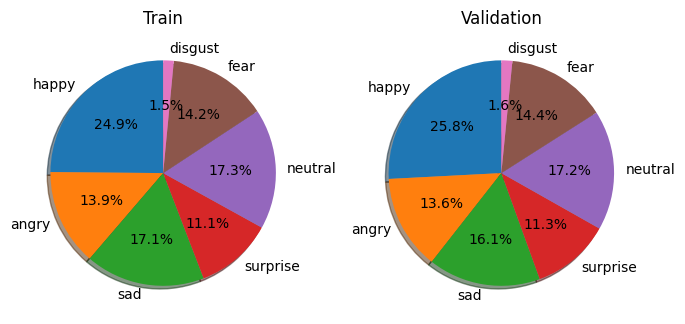

Emotion : happy
	Training : 7164
	 Testing : 1825
Emotion : angry
	Training : 3993
	 Testing : 960
Emotion : sad
	Training : 4938
	 Testing : 1139
Emotion : surprise
	Training : 3205
	 Testing : 797
Emotion : neutral
	Training : 4982
	 Testing : 1216
Emotion : fear
	Training : 4103
	 Testing : 1018
Emotion : disgust
	Training : 436
	 Testing : 111


In [6]:
x_train = np.array([ len(os.listdir(train_dir+i+'/')) for i in emotions ])
x_val = np.array([ len(os.listdir(val_dir+i+'/')) for i in emotions ])
label = emotions
  
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].pie(x_val, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Validation')
plt.show()

for i in emotions:
    print('Emotion : ' + i )
    print('\tTraining : ' + str(len(os.listdir(train_dir+i+'/'))) +'\n\t Testing : ' + str(len(os.listdir(val_dir+i+'/'))))

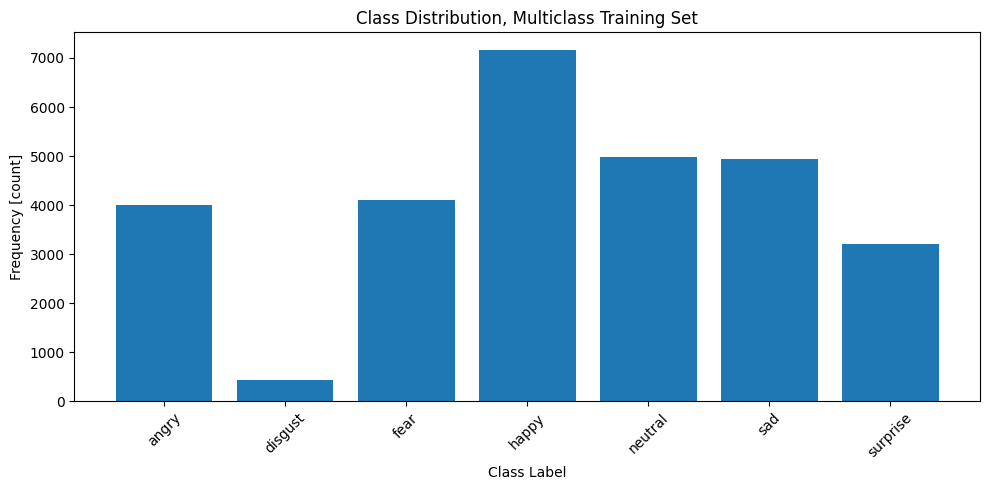

In [7]:
# Create a bar plot of class distributions
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the data
ax.bar(class_distributions.index, class_distributions.values)
ax.set_xlabel("Class Label")
ax.set_ylabel("Frequency [count]")
ax.set_title("Class Distribution, Multiclass Training Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Define path for hog image
happy_image_path = os.path.join(train_dir, "happy", "97.jpg")

# Define path for antelope image
neutral_image_path = os.path.join(train_dir, "neutral", "92.jpg")

print("happy_image_path type:", type(happy_image_path))
print(happy_image_path)
print()
print("neutral_image_path type:", type(neutral_image_path))
print(neutral_image_path)

happy_image_path type: <class 'str'>
C:/Users/DOCTOR PC/Documents/AI/emotion/images/train/happy\97.jpg

neutral_image_path type: <class 'str'>
C:/Users/DOCTOR PC/Documents/AI/emotion/images/train/neutral\92.jpg


happy_image_pil type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


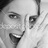

In [9]:
happy_image_pil = Image.open(happy_image_path)

print("happy_image_pil type:", type(happy_image_pil))
happy_image_pil

neutral_image_pil type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


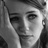

In [10]:
neutral_image_pil = Image.open(neutral_image_path)

print("neutral_image_pil type:", type(neutral_image_pil))
neutral_image_pil

In [11]:
happy_tensor = transforms.ToTensor()(happy_image_pil)

print("happy_tensor type:", type(happy_tensor))
print("happy_tensor shape:", happy_tensor.shape)
print("happy_tensor dtype:", happy_tensor.dtype)
print("happy_tensor device:", happy_tensor.device)

happy_tensor type: <class 'torch.Tensor'>
happy_tensor shape: torch.Size([1, 48, 48])
happy_tensor dtype: torch.float32
happy_tensor device: cpu


In [12]:
neutral_tensor = transforms.ToTensor()(neutral_image_pil)

print("neutral_tensor type:", type(neutral_tensor))
print("neutral_tensor shape:", neutral_tensor.shape)
print("neutral_tensor dtype:", neutral_tensor.dtype)
print("neutral_tensor device:", neutral_tensor.device)

neutral_tensor type: <class 'torch.Tensor'>
neutral_tensor shape: torch.Size([1, 48, 48])
neutral_tensor dtype: torch.float32
neutral_tensor device: cpu


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
transform = transforms.Compose(
[
transforms.ToTensor(),
transforms.Grayscale(num_output_channels=1)
]
)

print(type(transform))
print(transform)

<class 'torchvision.transforms.transforms.Compose'>
Compose(
    ToTensor()
    Grayscale(num_output_channels=1)
)


In [15]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 28821
    Root location: C:/Users/DOCTOR PC/Documents/AI/emotion/images/train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Grayscale(num_output_channels=1)
           )


In [16]:
dataset.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [17]:
print(dataset[0][0].shape)

torch.Size([1, 48, 48])


In [18]:
im = dataset.imgs
print(im[0])

distinct_classes = {x[1] for x in im}
print(distinct_classes)

('C:/Users/DOCTOR PC/Documents/AI/emotion/images/train/angry\\0.jpg', 0)
{0, 1, 2, 3, 4, 5, 6}


In [19]:
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=g)

In [20]:
print(f"Length of training set: {len(train_dataset)}")
print(f"Length of training set: {len(val_dataset)}")

Length of training set: 23057
Length of training set: 5764


In [21]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [22]:
#Takes a lot of time to run so run when time is sufficient

# train_counts = class_counts(train_dataset)
# train_counts

In [23]:
# will run only when we run the previous one

# train_counts.sort_values().plot(kind="bar");

In [24]:
#will run but takes a lot of time 

# val_counts = class_counts(val_dataset)
# val_counts.sort_values().plot(kind="bar");

In [25]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)

val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [26]:
single_batch = next(iter(train_loader))[0]
print(f"Shape of one batch: {single_batch.shape}")

Shape of one batch: torch.Size([32, 1, 48, 48])


In [27]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# This gives you [batch_size, channels, height, width] for images
image_shape = images.shape
print("Shape of batch of images", image_shape)

# This gives you [batch_size] for labels
label_shape = labels.shape
print("Shape of batch of labels:", label_shape)

Shape of batch of images torch.Size([32, 1, 48, 48])
Shape of batch of labels: torch.Size([32])


In [28]:
labels

tensor([4, 3, 0, 0, 4, 2, 6, 3, 5, 1, 4, 2, 2, 2, 4, 5, 3, 5, 6, 0, 5, 2, 0, 4,
        6, 5, 4, 5, 3, 5, 0, 6])

In [29]:
sample_confidence = torch.tensor([ 0.03, 0.12, 0.90, 0.34, 0.16, 0.12])
classes = dataset.classes

class_number = torch.argmax(sample_confidence)
prediction = classes[class_number]

print(f"This image is a {prediction}")

This image is a fear


## Buliding a Neural Network

In [30]:
model_seq = torch.nn.Sequential()

In [31]:
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1)
model_seq.append(conv1)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [32]:
test_batch = next(iter(train_loader))[0]

In [33]:
batch_shape = test_batch.shape

print(f"Batch shape: {batch_shape}")

Batch shape: torch.Size([32, 1, 48, 48])


In [34]:
first_step_out = model_seq(test_batch)

In [35]:
first_step_shape = first_step_out.shape

print(f"Shape after first convolution layer: {first_step_shape}")

Shape after first convolution layer: torch.Size([32, 16, 48, 48])


In [36]:
model_seq.append(torch.nn.ReLU())

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
)

In [37]:
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model_seq.append(max_pool1)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [38]:
max_pool_out = model_seq(test_batch)
max_pool_shape = max_pool_out

print(f"Shape after first max pool: {max_pool_shape}")

Shape after first max pool: tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[1.7943e-01, 1.7846e-01, 1.8365e-01,  ..., 1.8219e-01,
           1.7679e-01, 5.5308e-01],
          [1.8243e-01, 1.7910e-01, 1.8522e-01,  ..., 1.7773e-01,
           1.7848e-01, 5.5315e-01],
          [1.8419e-01, 1.8153e-01, 2.1673e-01,  ..., 1.8556e-01,
           1.8011e-01, 5.5208e-01],
          ...,
          [2.2656e-01, 2.4531e-

In [39]:
second_conv=torch.nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),padding=1)
second_pool=torch.nn.MaxPool2d(kernel_size=(2,2),stride=2)
model_seq.append(second_conv)
model_seq.append(torch.nn.ReLU())
model_seq.append(second_pool)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [40]:
second_set_out = model_seq(test_batch)

second_set_shape = second_set_out.shape

print(f"Shape after second max pool: {second_set_shape}")

Shape after second max pool: torch.Size([32, 32, 12, 12])


In [41]:
conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(2)
model_seq.append(conv3)
model_seq.append(torch.nn.ReLU())
model_seq.append(max_pool3)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [42]:
third_set_out = model_seq(test_batch)
third_set_shape = third_set_out.shape

print(f"Shape after third max pool: {third_set_shape}")

Shape after third max pool: torch.Size([32, 64, 6, 6])


In [43]:
model_seq.append(torch.nn.Flatten())

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
)

In [44]:
flat_out = model_seq(test_batch)
flat_shape = flat_out.shape

print(f"Shape after flattening: {flat_shape}")

Shape after flattening: torch.Size([32, 2304])


In [45]:
linear1 = torch.nn.Linear(in_features=2304, out_features=500)

model_seq.append(linear1)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2304, out_features=500, bias=True)
)

In [46]:
model_seq.append(torch.nn.ReLU())

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2304, out_features=500, bias=True)
  (11): ReLU()
)

In [47]:
linear_out = model_seq(test_batch)
linear_shape = linear_out.shape

print(f"Shape after linear layer: {linear_shape}")

Shape after linear layer: torch.Size([32, 500])


In [48]:
output_layer = torch.nn.Linear(500, 8)

model_seq.append(output_layer)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2304, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=8, bias=True)
)

In [49]:
model_seq(test_batch).shape

torch.Size([32, 8])

In [50]:
# Important! Don't change this
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.nn.Sequential()

conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1)
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(max_pool1)

conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
max_pool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout())

linear1 = torch.nn.Linear(in_features=2304, out_features=500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

output_layer = torch.nn.Linear(500, 8)
model.append(output_layer)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=2304, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)

In [51]:
height, width = 48 , 48 
summary(model, input_size=(batch_size, 1, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 8]                   --
├─Conv2d: 1-1                            [32, 16, 48, 48]          160
├─ReLU: 1-2                              [32, 16, 48, 48]          --
├─MaxPool2d: 1-3                         [32, 16, 24, 24]          --
├─Conv2d: 1-4                            [32, 32, 24, 24]          4,640
├─ReLU: 1-5                              [32, 32, 24, 24]          --
├─MaxPool2d: 1-6                         [32, 32, 12, 12]          --
├─Conv2d: 1-7                            [32, 64, 12, 12]          18,496
├─ReLU: 1-8                              [32, 64, 12, 12]          --
├─MaxPool2d: 1-9                         [32, 64, 6, 6]            --
├─Flatten: 1-10                          [32, 2304]                --
├─Dropout: 1-11                          [32, 2304]                --
├─Linear: 1-12                           [32, 500]                 1,152,500


In [52]:
from training import predict, train

In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=2304, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)

In [61]:
train(model,optimizer,loss_fn,train_loader,val_loader,epochs=25,device=device)

Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.95, Validation Loss: 1.20, Validation accuracy = 0.55


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.95, Validation Loss: 1.19, Validation accuracy = 0.55


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.93, Validation Loss: 1.19, Validation accuracy = 0.55


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.92, Validation Loss: 1.21, Validation accuracy = 0.55


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.91, Validation Loss: 1.20, Validation accuracy = 0.55


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.90, Validation Loss: 1.21, Validation accuracy = 0.55


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.89, Validation Loss: 1.20, Validation accuracy = 0.55


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.88, Validation Loss: 1.20, Validation accuracy = 0.56


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 0.87, Validation Loss: 1.20, Validation accuracy = 0.56


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 0.86, Validation Loss: 1.20, Validation accuracy = 0.55


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 11, Training Loss: 0.85, Validation Loss: 1.20, Validation accuracy = 0.55


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 12, Training Loss: 0.85, Validation Loss: 1.20, Validation accuracy = 0.56


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 13, Training Loss: 0.84, Validation Loss: 1.20, Validation accuracy = 0.56


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 14, Training Loss: 0.83, Validation Loss: 1.20, Validation accuracy = 0.56


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 15, Training Loss: 0.83, Validation Loss: 1.20, Validation accuracy = 0.55


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 16, Training Loss: 0.82, Validation Loss: 1.20, Validation accuracy = 0.56


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 17, Training Loss: 0.81, Validation Loss: 1.19, Validation accuracy = 0.56


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 18, Training Loss: 0.80, Validation Loss: 1.19, Validation accuracy = 0.56


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 19, Training Loss: 0.79, Validation Loss: 1.20, Validation accuracy = 0.56


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 20, Training Loss: 0.79, Validation Loss: 1.21, Validation accuracy = 0.55


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 21, Training Loss: 0.78, Validation Loss: 1.20, Validation accuracy = 0.56


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 22, Training Loss: 0.77, Validation Loss: 1.20, Validation accuracy = 0.55


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 23, Training Loss: 0.77, Validation Loss: 1.20, Validation accuracy = 0.56


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 24, Training Loss: 0.77, Validation Loss: 1.20, Validation accuracy = 0.56


Training:   0%|          | 0/721 [00:00<?, ?it/s]

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch: 25, Training Loss: 0.76, Validation Loss: 1.20, Validation accuracy = 0.55


In [62]:
#Tomorrow update the epoch size to 25 and see the accuracy , if it reaches 65 , continue to increase , other than that everything seems  fine

In [63]:
#search for adam optimizer if epoch dosen't work

In [64]:
#try hypertuning

In [65]:
#search for fine tuning

In [66]:
# #this is Flip, rotate, crop, scale, or add noise to increase dataset diversity. * Helps model generalize better.

# from torchvision import transforms
# from torchvision.datasets import ImageFolder  # or your dataset class
# from torch.utils.data import DataLoader


# train_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(),          # Randomly flip image horizontally
#     transforms.RandomRotation(15),              # Randomly rotate +/- 15 degrees
#     transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),  # Random crop and resize to 48x48
#     transforms.ToTensor(),                       # Convert PIL image to tensor
#     transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale image
# ])


# train_dataset = ImageFolder(root='path_to_train_data', transform=train_transforms)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# #try with this if works 

In [67]:
# or try mean and normalizaton from world quant ad see if that works

In [68]:
import pickle

# Save the model using pickle
with open('gradient_boosting_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)